### Cell 1: Summary
**Documentation**: # Claims Analysis — Production Notebook

# Claims Analysis — Production Notebook
**Version:** v1.0  
**Date:** September 03, 2025

This notebook is the **production-ready** version of the Claims Analysis workflow. It is intended to be stable and supportable by future maintainers without changing business logic or chart styling that have already been approved.

## Purpose
- Load claims data from approved sources
- Compute open-claims aging buckets and Pareto tables
- Render standardized Pareto charts (counts + cumulative %)
- Provide outputs suitable for leadership review and downstream dashboards

> ⚠️ **Change Control:** Treat this notebook as controlled. If you modify logic, increment the version (v1.1, v1.2, …) and update the changelog at the end.


### Cell 2: Summary
**Documentation**: ## Function Index 


## Function Index of functions detected in code cells to aid future support. Docstrings are shown if present.

| Function | Signature | Docstring summary |
|---|---|---|
| `resolve_path` | `(fname)` | — |
| `load_and_prepare` | `(path, sheet, dataset_name)` | — |
| `apply_date_filter` | `(df, mode, start_str, end_str)` | — |
| `explode_labels` | `(df)` | — |
| `compute_bucket_perf` | `(df)` | — |
| `compute_overall_pareto` | `(labels_exploded)` | — |
| `compute_by_wh_pareto` | `(labels_exploded, warehouses)` | — |
| `plot_pareto` | `(sub, title, top_n)` | — |
| `in_range` | `(series)` | — |
| `_normalize_name` | `(s)` | — |
| `_find_col` | `(actual_cols, candidates)` | — |
| `_pick_claims_df` | `()` | — |
| `_pick_claims_df_for_aging` | `()` | — |
| `_classify_age_bucket` | `(days)` | — |
| `_resolve_aging_source` | `()` | — |

### Cell 3: Summary
**Documentation**: # Claims Analysis v0.1 — Multi-File, Date Range, Pareto, Aging, and Open Claims Summary

# Claims Analysis v1.0— Multi-File, Date Range, Pareto, Aging, and Open Claims Summary

This notebook analyzes dealer claims from multiple Excel files, applies a date range filter, computes performance and Pareto tables, and summarizes open claims and aging buckets by warehouse.

### Cell 4: Summary
- Import and environment setup
- Render charts

In [11]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

### Cell 5: Summary
- Configure analysis constants/parameters
- Filter/select records
- Compute aging and bucketization

In [12]:
# %%
# ----------------------------
# Parameters (EDITABLE)
# ----------------------------
INPUT_FILES = [
    {"name": "Claims", "filename": "Claims.xlsx"},
    {"name": "Chrysler Claims", "filename": "Chrysler Claims.xlsx"},
]
SHEET_NAME = "Tasks"
OUTPUT_XLSX = Path("Claims_Performance_Summary_ALL.xlsx")
WAREHOUSES = ["OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"]
MAIN_WAREHOUSES = ["OKC", "Phoenix", "Ontario", "El Paso", "Flowood", "Orlando", "Atlanta", "Charlotte"]
TOP_N_LABELS = 15
DATE_FILTER_MODE = "Created"
START_DATE = "2025-01-01"
END_DATE = "2025-12-31"
BUCKET_ORDER = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
bucket_regex_map = {
    r'^\s*<\s*30.*$'                 : '<30 days',
    r'^\s*30\s*-\s*<\s*60.*$'        : '30-<60 days',
    r'^\s*60\s*-\s*<\s*90.*$'        : '60-<90 days',
    r'^\s*(?:>=?\s*90|90\+|>\s*90).*': '>= 90 days',
}

### Cell 6: Summary
- Define helper functions: resolve_path, load_and_prepare, apply_date_filter, explode_labels, compute_bucket_perf, compute_overall_pareto…
- Load input data
- Save outputs
- Transform/aggregate data
- Filter/select records
- Compute aging and bucketization
- Render charts
- Display results

In [13]:
# %%
def resolve_path(fname: str) -> Path:
    p = Path(fname)
    if p.exists():
        return p
    fallback = Path("/mnt/data") / fname
    if fallback.exists():
        return fallback
    raise FileNotFoundError(f"Could not find input Excel '{fname}' at {p.resolve()} or {fallback.resolve()}")

def load_and_prepare(path: Path, sheet: str, dataset_name: str) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    if sheet not in xls.sheet_names:
        raise ValueError(f"Sheet '{sheet}' not found in {path.name}. Available: {xls.sheet_names}")
    df = pd.read_excel(path, sheet_name=sheet)
    required = ["Bucket Name", "Labels", "Created Date", "Completed Date"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Expected column '{col}' not found in {path.name}/{sheet}")
    df["Bucket Name"] = df["Bucket Name"].astype(str).str.strip()
    df["Labels"] = df["Labels"].astype(str).str.strip()
    df["Created Date"] = pd.to_datetime(df["Created Date"], errors="coerce")
    df["Completed Date"] = pd.to_datetime(df["Completed Date"], errors="coerce")
    df["Cycle Time (Days)"] = (df["Completed Date"] - df["Created Date"]).dt.days
    df["Dataset"] = dataset_name
    return df

def apply_date_filter(df: pd.DataFrame, mode: str, start_str, end_str) -> pd.DataFrame:
    if not start_str and not end_str:
        return df.copy()
    start = pd.to_datetime(start_str) if start_str else None
    end = pd.to_datetime(end_str) if end_str else None
    created = df["Created Date"]
    completed = df["Completed Date"]
    def in_range(series):
        mask = pd.Series(True, index=series.index)
        if start is not None:
            mask &= series >= start
        if end is not None:
            mask &= series <= end
        return mask
    if mode.lower().startswith("created"):
        mask = in_range(created)
    elif mode.lower().startswith("completed"):
        mask = in_range(completed)
    else:
        mask = in_range(created)
        mask |= in_range(completed)
    return df[mask].copy()

def explode_labels(df: pd.DataFrame) -> pd.DataFrame:
    out = df[["Dataset", "Bucket Name", "Labels"]].copy()
    out = out.assign(Labels=out["Labels"].str.split(";")).explode("Labels")
    out["Labels"] = out["Labels"].astype(str).str.strip()
    out = out[out["Labels"].ne("")]
    return out

def compute_bucket_perf(df: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df.groupby(["Dataset", "Bucket Name"])["Cycle Time (Days)"]
          .agg(["count", "mean", "median", "min", "max"])
          .reset_index()
    )
    agg.rename(columns={
        "count": "Count",
        "mean": "Mean (days)",
        "median": "Median (days)",
        "min": "Min (days)",
        "max": "Max (days)"
    }, inplace=True)
    agg["Mean (days)"] = agg["Mean (days)"].round(2)
    agg["Median (days)"] = agg["Median (days)"].round(2)
    return agg

def compute_overall_pareto(labels_exploded: pd.DataFrame) -> pd.DataFrame:
    vc = labels_exploded["Labels"].value_counts().rename_axis("Label").reset_index(name="Count")
    total = vc["Count"].sum()
    vc["Cumulative %"] = (vc["Count"].cumsum() / total * 100).round(2)
    vc.insert(0, "Dataset", "ALL")
    return vc

def compute_by_wh_pareto(labels_exploded: pd.DataFrame, warehouses: list[str]) -> pd.DataFrame:
    wh = labels_exploded[labels_exploded["Bucket Name"].isin(warehouses)].copy()
    wh.rename(columns={"Bucket Name": "Warehouse"}, inplace=True)
    counts = (
        wh.groupby(["Dataset", "Warehouse", "Labels"])
          .size()
          .reset_index(name="Count")
    )
    counts["Percent"] = counts.groupby(["Dataset", "Warehouse"])["Count"].transform(lambda x: x / x.sum() * 100).round(2)
    counts = counts.sort_values(["Dataset", "Warehouse", "Count"], ascending=[True, True, False])
    counts["Cumulative %"] = counts.groupby(["Dataset", "Warehouse"])["Count"].transform(lambda x: (x.cumsum() / x.sum() * 100)).round(2)
    return counts

def plot_pareto(sub: pd.DataFrame, title: str, top_n=None):
    sub_sorted = sub.sort_values("Count", ascending=False)
    if top_n is not None:
        sub_sorted = sub_sorted.head(int(top_n))
    labels = sub_sorted["Labels"].tolist()
    counts = sub_sorted["Count"].tolist()
    cum_pct = sub_sorted["Cumulative %"].tolist()
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.gca()
    ax1.bar(labels, counts)
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")
    ax1.set_title(title)
    ax2 = ax1.twinx()
    ax2.plot(range(len(labels)), cum_pct, marker="o")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100)
    ax1.tick_params(axis="x", rotation=45, labelsize=9)
    fig.tight_layout()
    plt.show()

### Cell 7: Summary
- Configure analysis constants/parameters
- Filter/select records
- Display results

In [14]:
# %%
frames = []
missing = []
for item in INPUT_FILES:
    try:
        p = resolve_path(item["filename"])
        df_i = load_and_prepare(p, SHEET_NAME, dataset_name=item["name"])
        frames.append(df_i)
        print(f"Loaded {len(df_i):,} rows from {item['filename']} as dataset '{item['name']}'")
    except Exception as e:
        missing.append((item["filename"], str(e)))
        print(f"WARNING: Skipping '{item['filename']}' -> {e}")

if not frames:
    raise RuntimeError("No datasets loaded. Ensure input files exist.")

df_all = pd.concat(frames, ignore_index=True)
print(f"Before date filter: {len(df_all):,} rows")

df_filtered = apply_date_filter(df_all, DATE_FILTER_MODE, START_DATE, END_DATE)
print(f"After date filter ({DATE_FILTER_MODE}, {START_DATE} to {END_DATE}): {len(df_filtered):,} rows")
df_filtered.head(3)

Loaded 3,533 rows from Claims.xlsx as dataset 'Claims'
Loaded 2,924 rows from Chrysler Claims.xlsx as dataset 'Chrysler Claims'
Before date filter: 6,457 rows
After date filter (Created, 2025-01-01 to 2025-12-31): 3,683 rows


,Task ID,Task Name,Bucket Name,Progress,Priority,Assigned To,Created By,Created Date,Start date,Due date,Is Recurring,Late,Completed Date,Completed By,Completed Checklist Items,Checklist Items,Labels,Description,Cycle Time (Days),Dataset
0,-0qzZOLigUCL_5_jyscqrWUAEUa6,CHARLOTTE - CHRYSLER SHORTAGE - 1308667 - 6843...,Charlotte,Completed,Medium,Scott Grady;Janet Jones,Former member,2025-01-13,01/13/2025,01/28/2025,False,False,2025-02-05,Heather LaMar,5/7,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,23.0,Claims
7,-94D9gbcmE6cCIxP3vcSl2UAP12N,ATLANTA - CHRYSLER SHORTAGE - 0831173 - MULTI ...,Chrysler Pending Set Up - Shortages,Completed,Medium,NaN,Former member,2025-02-10,02/10/2025,02/14/2025,False,False,2025-02-12,Heather LaMar,0/6,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,2.0,Claims
8,-9Hm2TdIvE-mILH0mZaAXWUAMnMB,FL3Z7902FRM - 05530 - BANNER FORD OF MONROE - ...,Flowood,In progress,Medium,Megan McLaughlin;Nidia Jimenez;Kristi Thompson...,Megan McLaughlin,2025-07-28,07/28/2025,09/19/2025,False,False,NaT,NaN,5/9,Add to Log (Acctg);Pick Up Sheet/RMA completed...,CD - Conceal damaged ;upload BOL or Tracking/n...,**(IT'S NOT BE VISIBLE IF IT SHIPPED FROM A FR...,NaN,Claims


### Cell 8: Summary
- Filter/select records
- Compute aging and bucketization
- Display results

In [15]:
# %%
bucket_perf_by_dataset = compute_bucket_perf(df_filtered)
df_filtered_all = df_filtered.copy()
df_filtered_all["Dataset"] = "ALL"
bucket_perf_all = compute_bucket_perf(df_filtered_all)
bucket_perf_by_dataset.head(10)
bucket_perf_all.head(10)

,Dataset,Bucket Name,Count,Mean (days),Median (days),Min (days),Max (days)
0,ALL,900,4,23.75,23.5,16.0,32.0
1,ALL,900-SHORTAGE PROBLEMS,4,35.75,20.0,15.0,88.0
2,ALL,Atlanta,104,52.05,41.0,1.0,138.0
3,ALL,CD Claims for AER/Holman customers,40,35.98,36.5,13.0,64.0
4,ALL,Charlotte,107,34.30,28.0,0.0,156.0
5,ALL,Chrysler Credits Pending - Shortages,369,43.67,38.0,7.0,210.0
6,ALL,Chrysler Pending Set Up - Shortages,27,5.63,6.0,1.0,12.0
7,ALL,Chrysler Pending Set-Up - Shortages,528,6.67,5.0,0.0,19.0
8,ALL,Claim template,0,NaN,NaN,NaN,NaN
9,ALL,El Paso,14,37.43,29.5,3.0,154.0


### Cell 9: Summary
**Documentation**: 7. Pareto Calcuations

7. Pareto Calcuations

### Cell 10: Summary
- Transform/aggregate data
- Filter/select records
- Display results

In [16]:
# %%
labels_exploded = explode_labels(df_filtered)
overall_all = compute_overall_pareto(labels_exploded)
overall_by_dataset = (
    labels_exploded.groupby(["Dataset", "Labels"])
                   .size().reset_index(name="Count")
                   .sort_values(["Dataset", "Count"], ascending=[True, False])
)
overall_by_dataset["Cumulative %"] = (
    overall_by_dataset.groupby("Dataset")["Count"].transform(lambda x: x.cumsum() / x.sum() * 100)
).round(2)

by_wh = compute_by_wh_pareto(labels_exploded, WAREHOUSES)
labels_exploded_all = labels_exploded.copy()
labels_exploded_all["Dataset"] = "ALL"
by_wh_all = compute_by_wh_pareto(labels_exploded_all, WAREHOUSES)
overall_all.head(15)

,Dataset,Label,Count,Cumulative %
0,ALL,DD/DB Shortage,2795,68.17
1,ALL,CD - Concealed Damage,428,78.61
2,ALL,CD - Conceal damaged,263,85.02
3,ALL,Shelf Count,116,87.85
4,ALL,AER Filed Claim,57,89.24
5,ALL,SHELF COUNT,53,90.54
6,ALL,Outbound freight damage,44,91.61
7,ALL,Scrap Part,37,92.51
8,ALL,DB short engines & transmissions,33,93.32
9,ALL,CF Misboxed,30,94.05


### Cell 11: Summary
**Documentation**: 8. Pareto Charts

8. Pareto Charts

### Cell 12: Summary
- Filter/select records

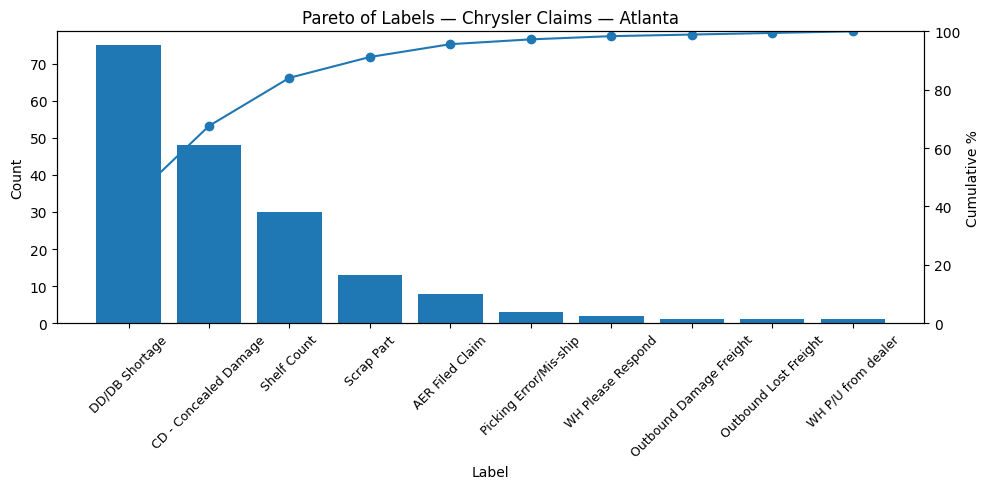

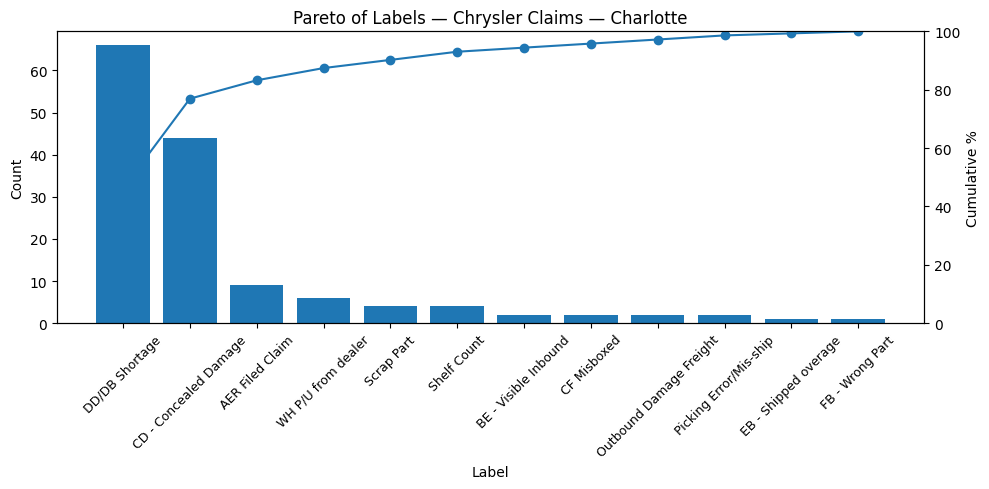

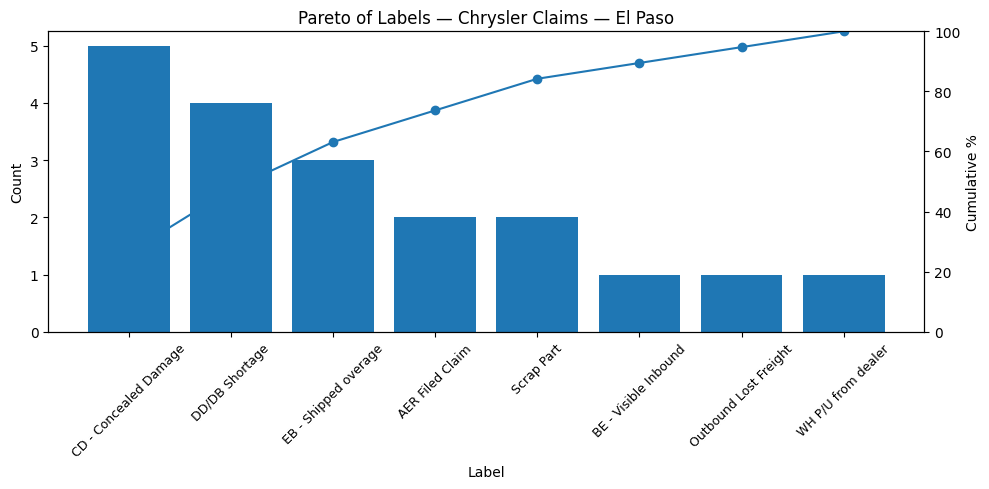

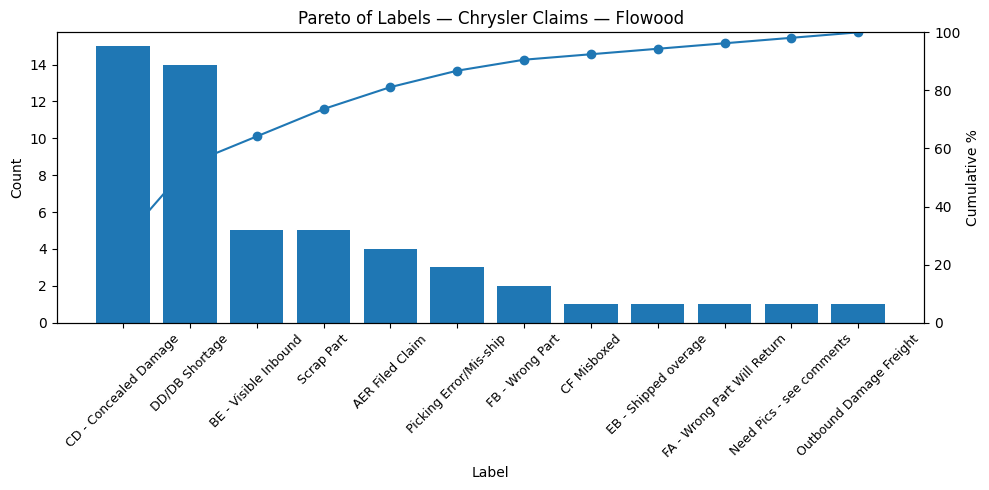

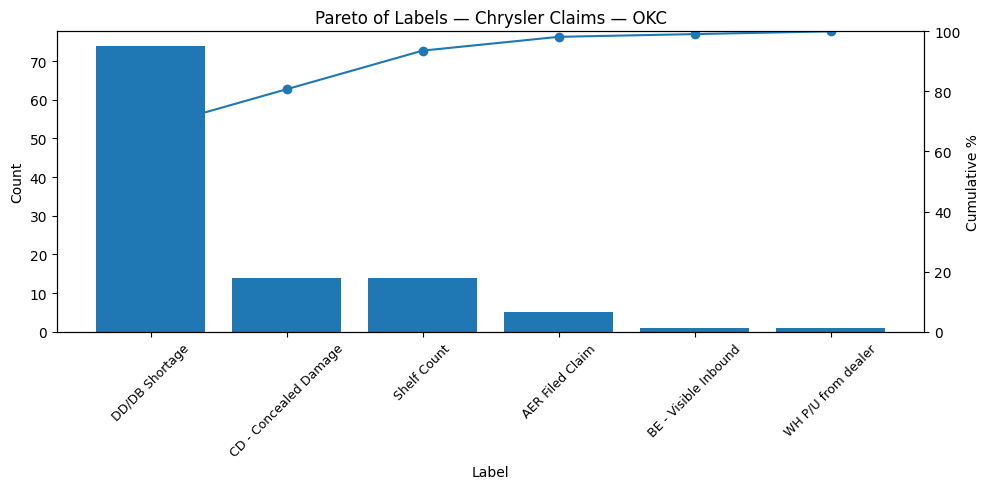

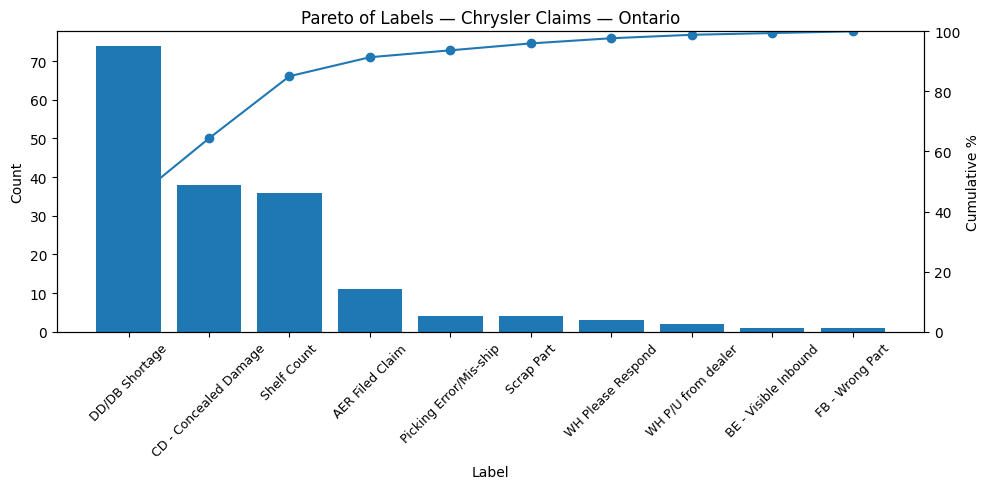

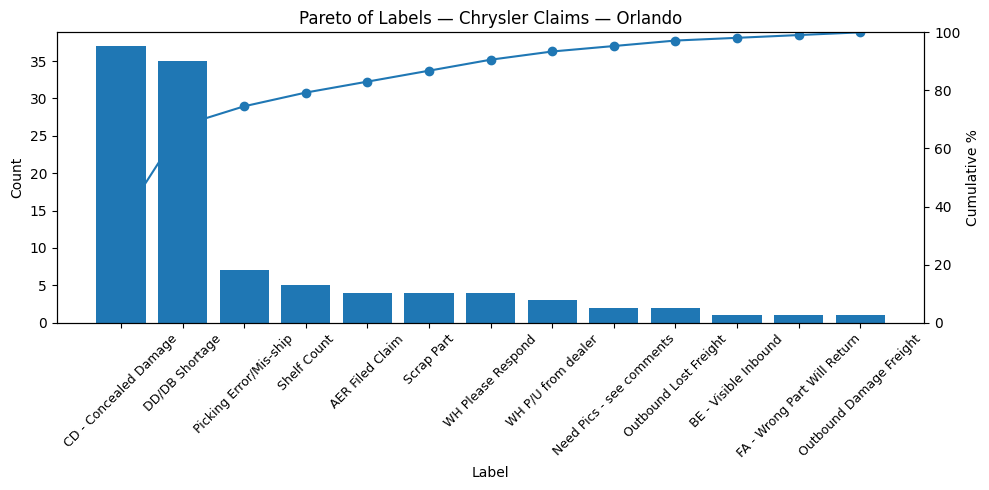

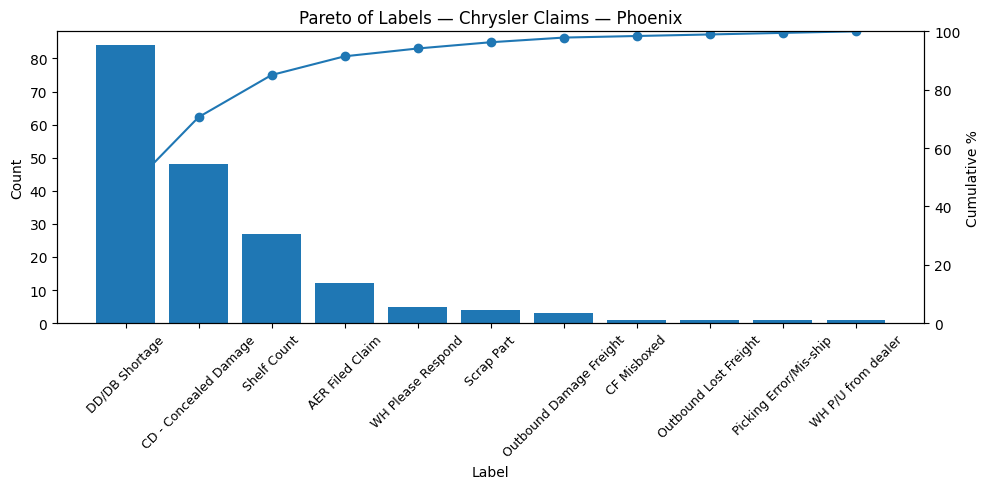

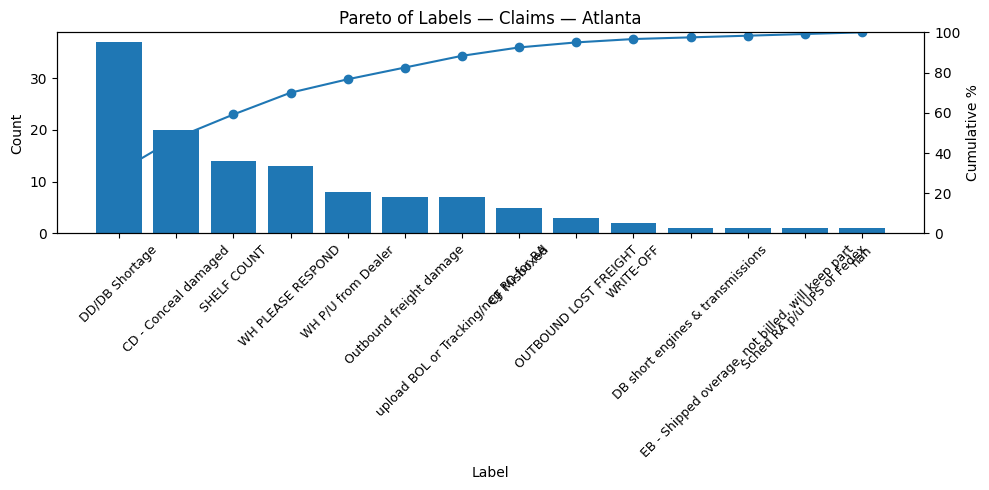

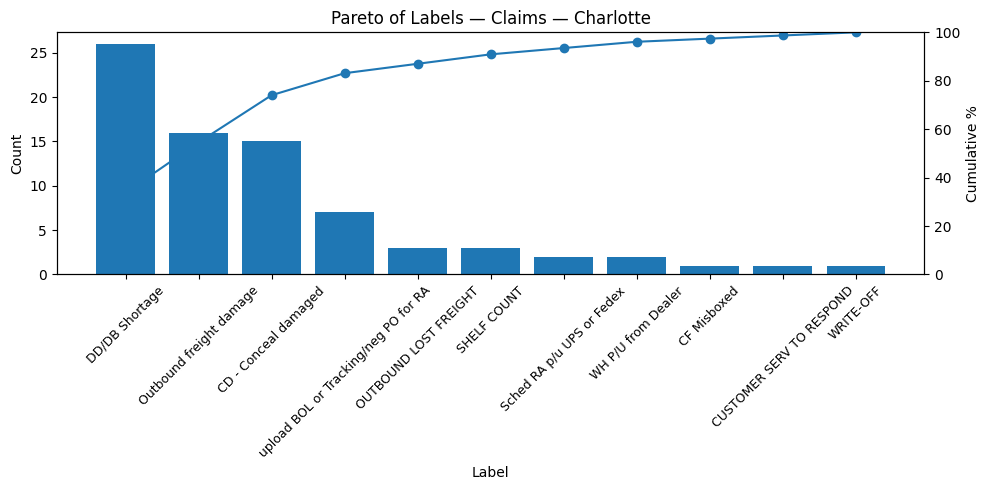

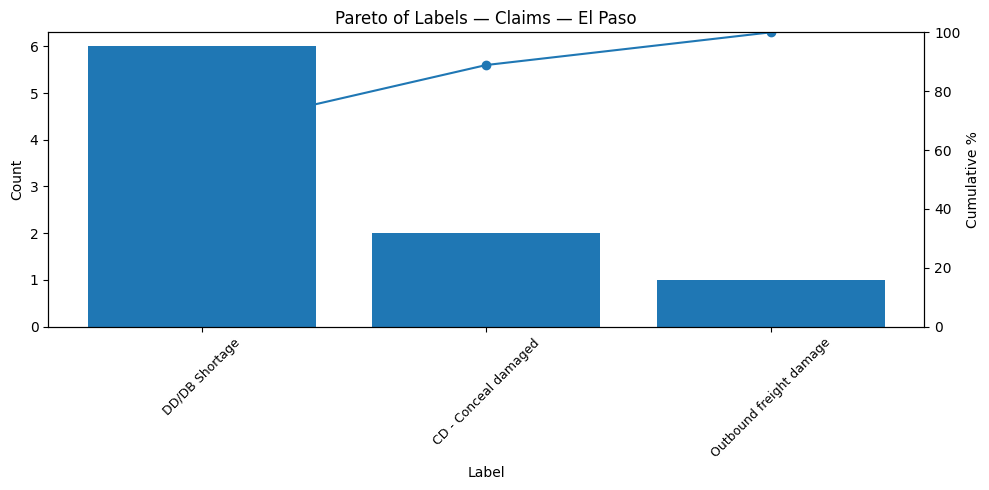

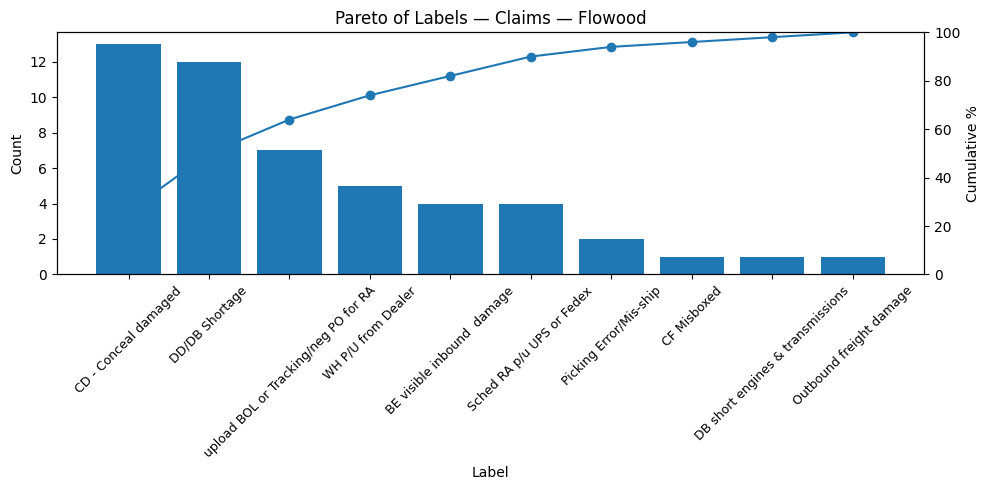

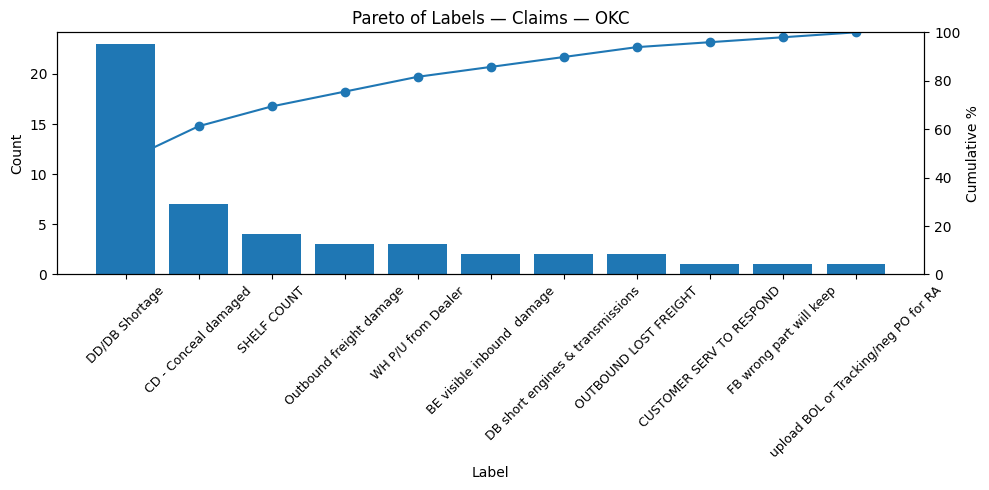

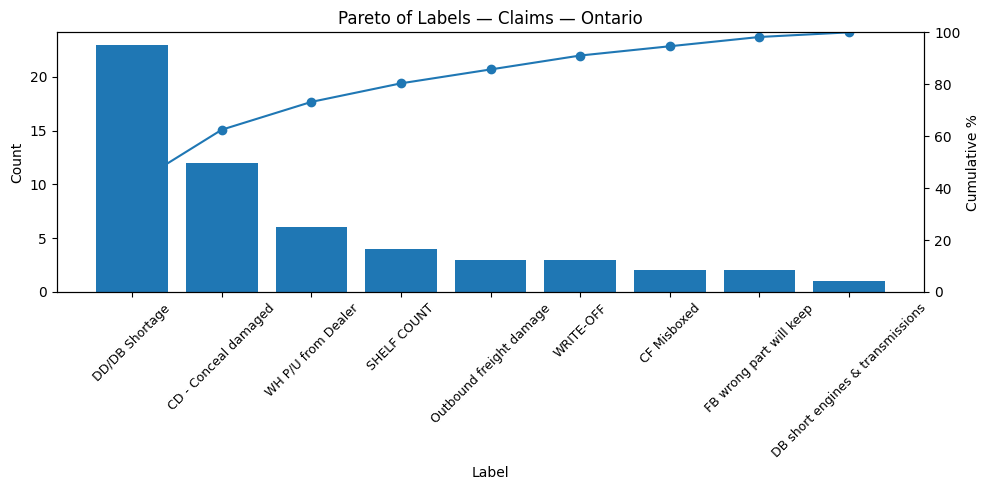

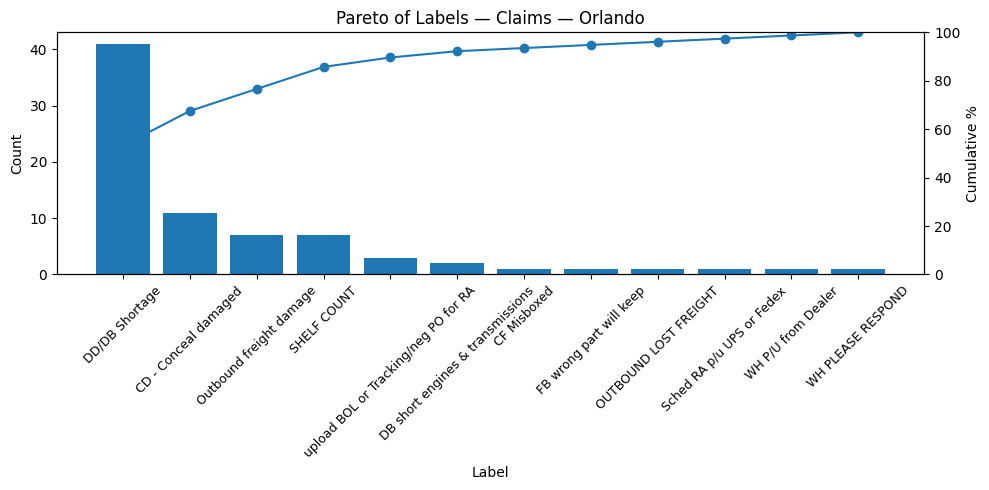

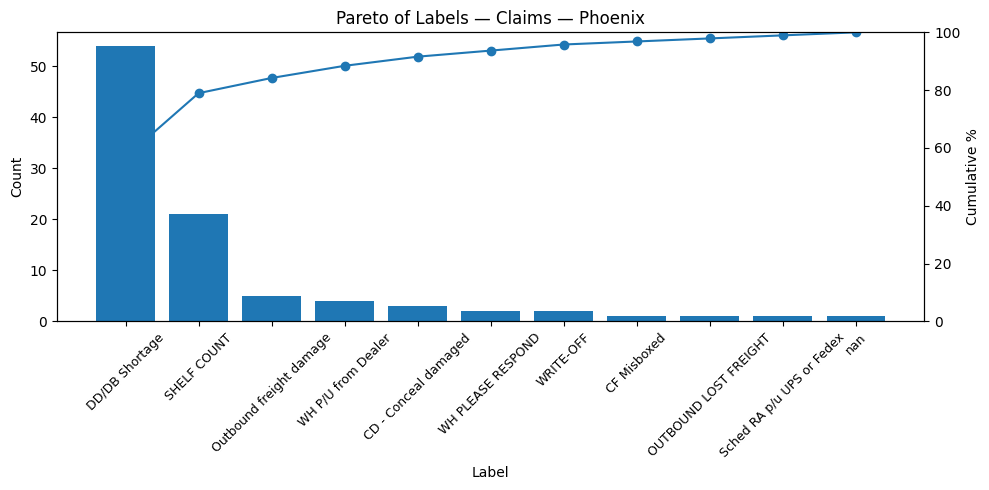

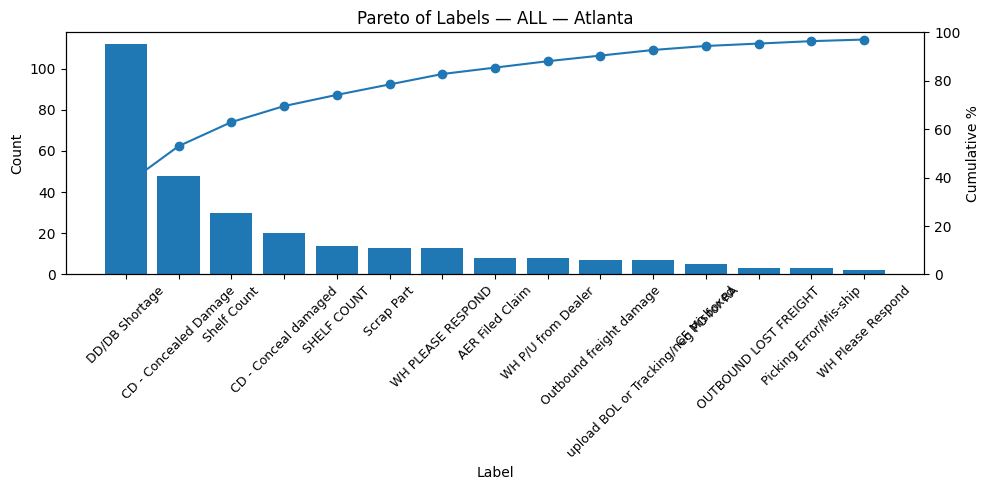

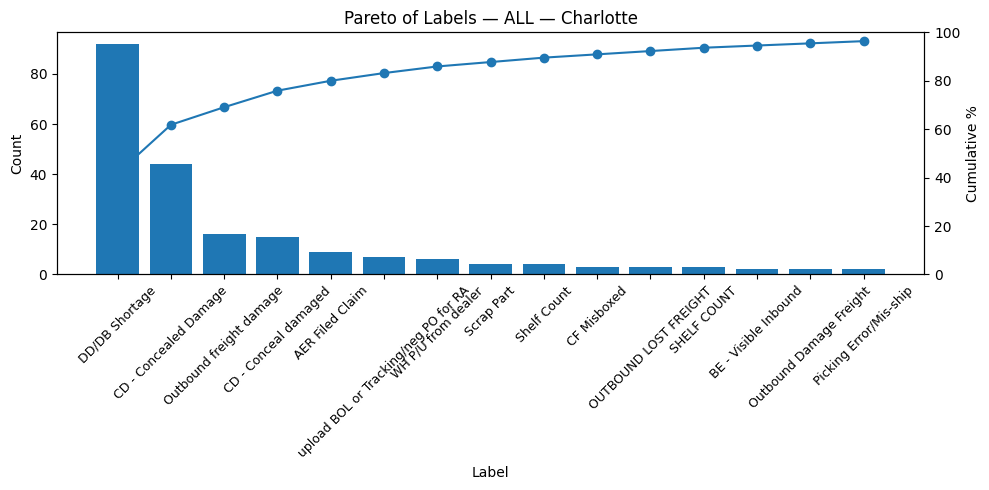

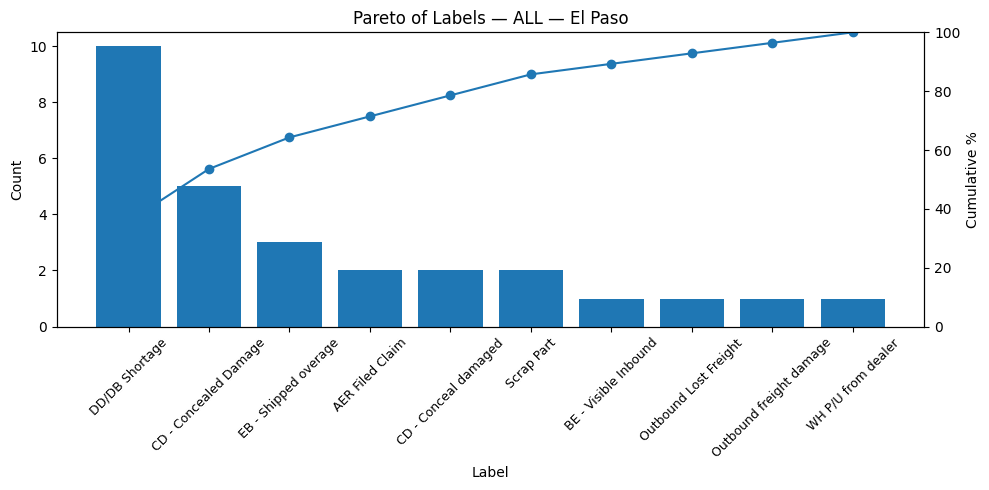

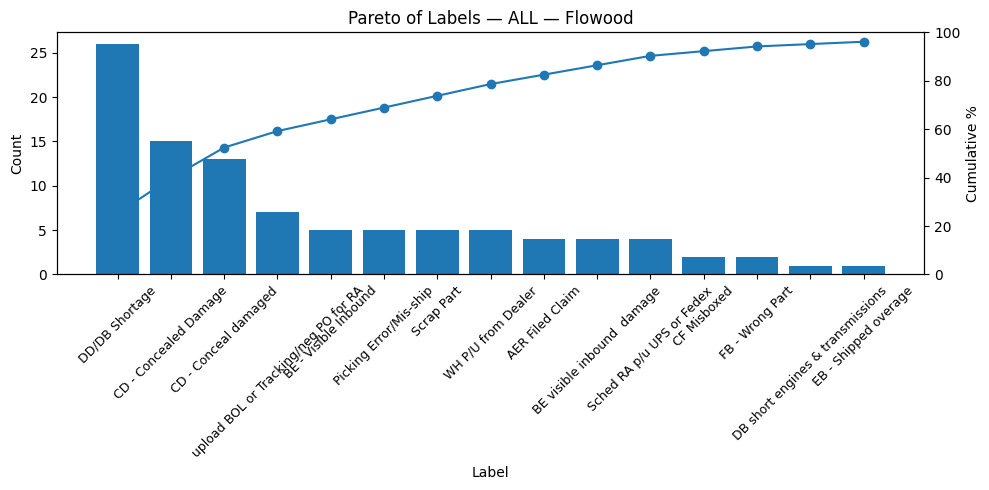

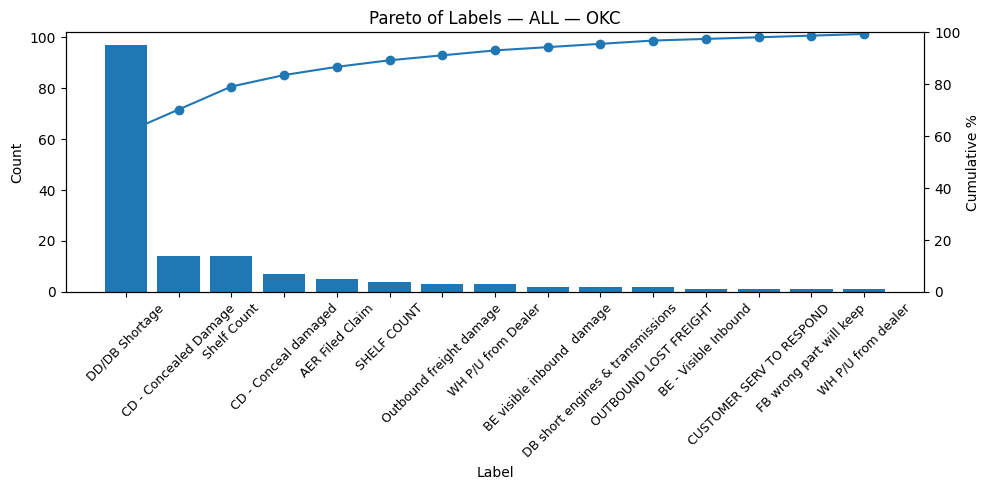

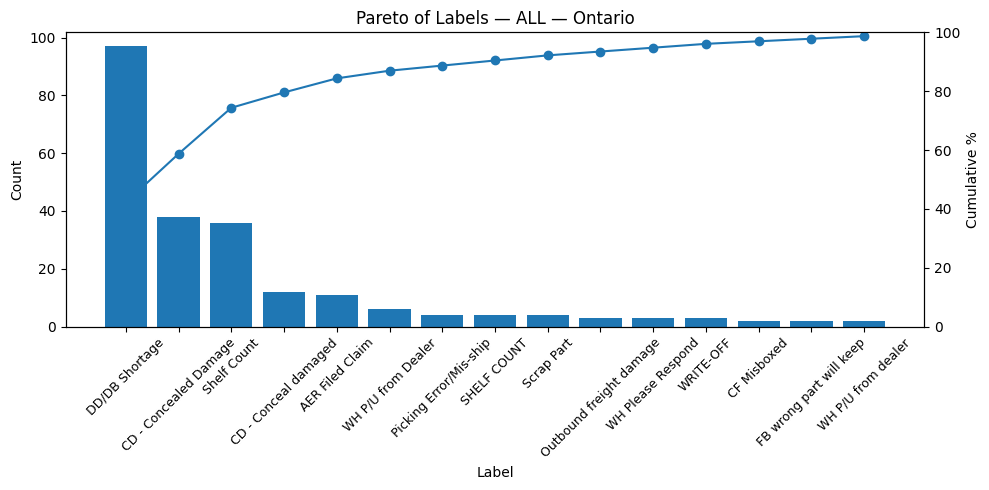

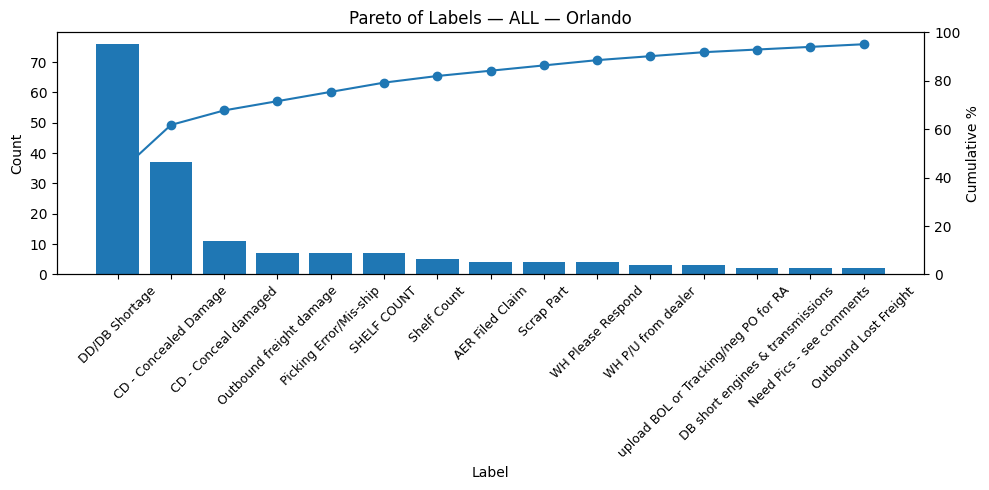

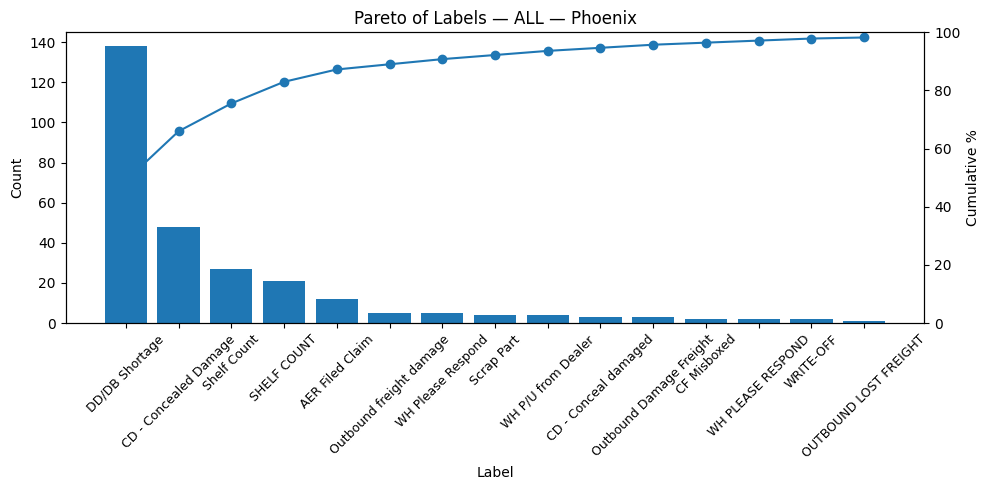

In [17]:
# %%
for ds in sorted(by_wh["Dataset"].unique()):
    for wh in sorted(by_wh[by_wh["Dataset"] == ds]["Warehouse"].unique()):
        sub = by_wh[(by_wh["Dataset"] == ds) & (by_wh["Warehouse"] == wh)]
        if not sub.empty:
            plot_pareto(sub, f"Pareto of Labels — {ds} — {wh}", top_n=TOP_N_LABELS)

for wh in sorted(by_wh_all["Warehouse"].unique()):
    sub = by_wh_all[by_wh_all["Warehouse"] == wh]
    if not sub.empty:
        plot_pareto(sub, f"Pareto of Labels — ALL — {wh}", top_n=TOP_N_LABELS)

### Cell 13: Summary
**Documentation**: 9. Export Results

9. Export Results

### Cell 14: Summary
- Save outputs
- Filter/select records
- Compute aging and bucketization
- Display results

In [18]:
# %%
overall_all_export = overall_all.copy()
overall_by_dataset_export = overall_by_dataset.copy()
overall_combined = pd.concat([overall_all_export, overall_by_dataset_export], ignore_index=True)
by_wh_combined = pd.concat([by_wh, by_wh_all], ignore_index=True)

with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    bucket_perf_by_dataset.to_excel(writer, sheet_name="Bucket_Performance", index=False)
    bucket_perf_all.to_excel(writer, sheet_name="Bucket_Performance_ALL", index=False)
    overall_combined.to_excel(writer, sheet_name="Pareto_Labels_Overall", index=False)
    by_wh_combined.to_excel(writer, sheet_name="Pareto_Labels_By_Warehouse", index=False)
    df_filtered.to_excel(writer, sheet_name="Detailed_Data", index=False)
print(f"Exported (filtered) Power BI workbook -> {OUTPUT_XLSX.resolve()}")

Exported (filtered) Power BI workbook -> C:\Users\dbalan\Desktop\Python\Github\Claims\Claims_Performance_Summary_ALL.xlsx


### Cell 15: Summary
**Documentation**: 10. Open Claims Summary by Warehouse

10. Open Claims Summary by Warehouse

### Cell 16: Summary
- Define helper functions: _normalize_name, _find_col, _pick_claims_df
- Save outputs
- Transform/aggregate data
- Filter/select records
- Compute aging and bucketization
- Display results

In [19]:
# %%
def _normalize_name(s: str) -> str:
    return str(s).strip().lower()

def _find_col(actual_cols, candidates):
    lookup = {_normalize_name(c): c for c in actual_cols}
    for cand in candidates:
        key = _normalize_name(cand)
        if key in lookup:
            return lookup[key]
    raise KeyError(f"None of the candidates {candidates} found in columns: {list(actual_cols)}")

def _pick_claims_df():
    candidates = ["df_filtered", "df_all", "df", "tasks", "claims"]
    for name in candidates:
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            df = globals()[name]
            try:
                _ = df.columns
            except Exception:
                continue
            return df, name
    raise RuntimeError(
        "Could not find a DataFrame in variables: df_filtered, df_all, df, tasks, claims.\n"
        "Please ensure your claims data is in one of those variables."
    )

_src_df, _src_name = _pick_claims_df()
claims_df = _src_df.copy()
cols = list(claims_df.columns)
bucket_candidates   = ["Bucket Name", "Bucket", "Warehouse", "Location", "Site", "Facility"]
completed_candidates = ["Completed Date", "Completed", "Date Completed", "Completion Date", "Closed Date"]
dataset_candidates   = ["Dataset"]

try:
    bucket_col = _find_col(cols, bucket_candidates)
except KeyError as e:
    raise KeyError("Could not detect your warehouse/bucket column. "
                   "Add one of these: 'Bucket Name', 'Bucket', 'Warehouse', 'Location', 'Site', 'Facility'.") from e

try:
    completed_col = _find_col(cols, completed_candidates)
except KeyError as e:
    raise KeyError("Could not detect your completed-date column. "
                   "Add one of these: 'Completed Date', 'Completed', 'Date Completed', 'Completion Date', 'Closed Date'.") from e

has_dataset = False
if any(_normalize_name(c) == "dataset" for c in cols):
    dataset_col = [c for c in cols if _normalize_name(c) == "dataset"][0]
    has_dataset = True

open_mask = claims_df[completed_col].isna()
open_df = claims_df.loc[open_mask].copy()
open_df["Warehouse"] = open_df[bucket_col]
group_fields = ["Warehouse"]
if has_dataset:
    group_fields.insert(0, dataset_col)

open_by_wh = (
    open_df
    .groupby(group_fields)
    .size()
    .reset_index(name="Open Count")
    .sort_values(group_fields + ["Open Count"], ascending=[True]*len(group_fields) + [False])
    .reset_index(drop=True)
)

print("Open claims by warehouse" + (" (by Dataset)" if has_dataset else "") + ":")
display(open_by_wh.head(100))

if has_dataset:
    open_by_wh_all = (
        open_by_wh
        .assign(**{dataset_col: "ALL"})
        .groupby([dataset_col, "Warehouse"], as_index=False)
        .agg({"Open Count": "sum"})
        .sort_values(["Warehouse"])
        .reset_index(drop=True)
    )
    print("\nOpen claims by warehouse — ALL datasets combined:")
    display(open_by_wh_all.head(100))

try:
    if "OUTPUT_XLSX" in globals():
        with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            open_by_wh.to_excel(writer, sheet_name="Open_Claims_By_Warehouse_Addon", index=False)
            if has_dataset:
                open_by_wh_all.to_excel(writer, sheet_name="Open_Claims_By_Warehouse_Addon_ALL", index=False)
        print(f"\n(Appended open-claims summaries to {OUTPUT_XLSX})")
except Exception as e:
    print(f"\nSkipping Excel export of open-claims summary: {e}")

Open claims by warehouse (by Dataset):


,Dataset,Warehouse,Open Count
0,Chrysler Claims,Atlanta,61
1,Chrysler Claims,CD Claims for AER/Holman customers,79
2,Chrysler Claims,Charlotte,44
3,Chrysler Claims,Chrysler Credits Pending - Shortages,630
4,Chrysler Claims,Chrysler Pending Set-Up - Shortages,85
5,Chrysler Claims,El Paso,8
6,Chrysler Claims,Flowood,14
7,Chrysler Claims,No Bucket,55
8,Chrysler Claims,OKC,23
9,Chrysler Claims,Ontario,63



Open claims by warehouse — ALL datasets combined:


,Dataset,Warehouse,Open Count
0,ALL,Atlanta,99
1,ALL,CD Claims for AER/Holman customers,79
2,ALL,Charlotte,69
3,ALL,Chrysler Credits Pending - Shortages,630
4,ALL,Chrysler Pending Set-Up - Shortages,85
5,ALL,Claim template,4
6,ALL,El Paso,9
7,ALL,Flowood,32
8,ALL,Ford Credits Pending - Damages,19
9,ALL,Ford Credits Pending - Shortages,24


c:\Users\dbalan\Desktop\Python\Github\Claims\.venv\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")



(Appended open-claims summaries to Claims_Performance_Summary_ALL.xlsx)


### Cell 17: Summary
**Documentation**: 11. Aging Pareto for Main Warehouses

11. Aging Pareto for Main Warehouses

### Cell 18: Summary
- Define helper functions: _normalize_name, _find_col, _pick_claims_df_for_aging, _classify_age_bucket, _resolve_aging_source
- Configure analysis constants/parameters
- Transform/aggregate data
- Filter/select records
- Compute aging and bucketization
- Render charts

C:\Users\dbalan\AppData\Local\Temp\ipykernel_16364\3767429937.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pareto = (src.groupby(["Warehouse", "Aging Bucket"], as_index=False)["Open Count"]


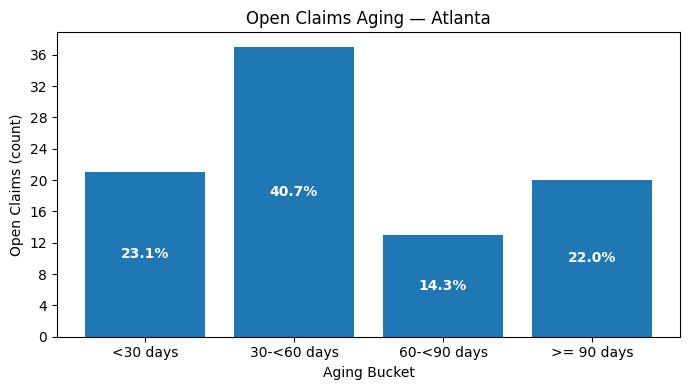

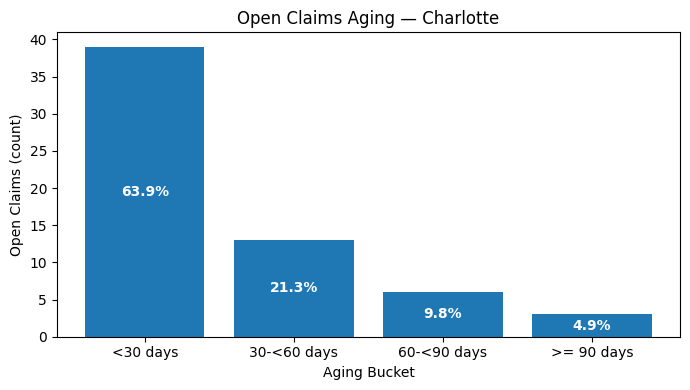

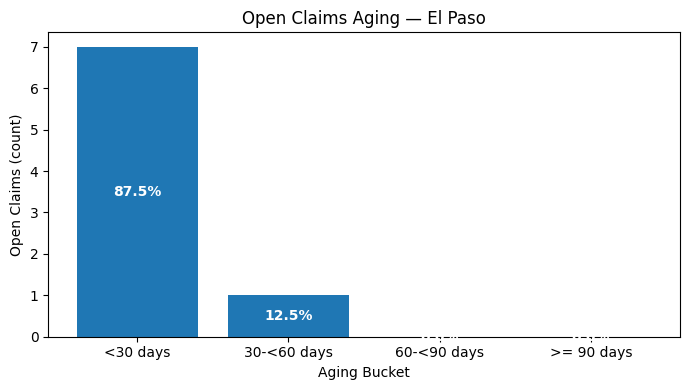

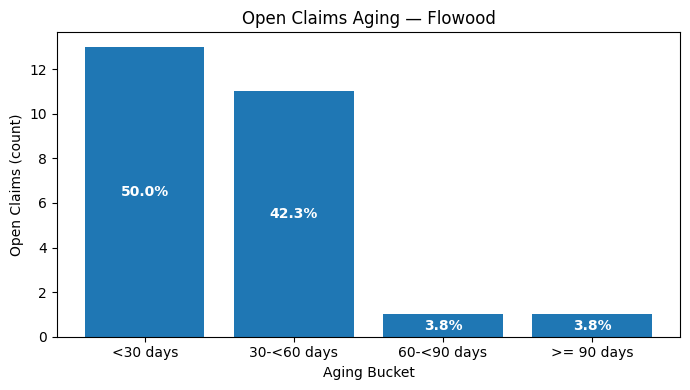

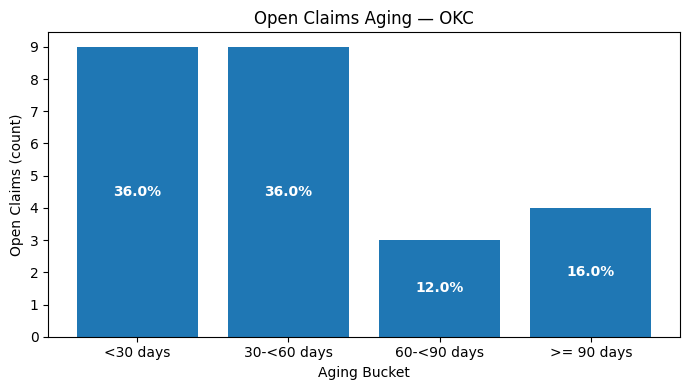

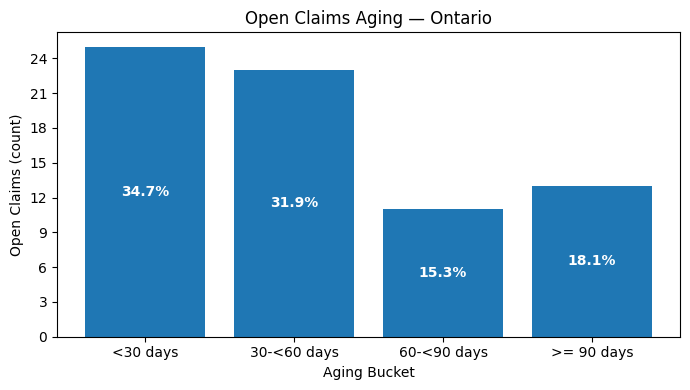

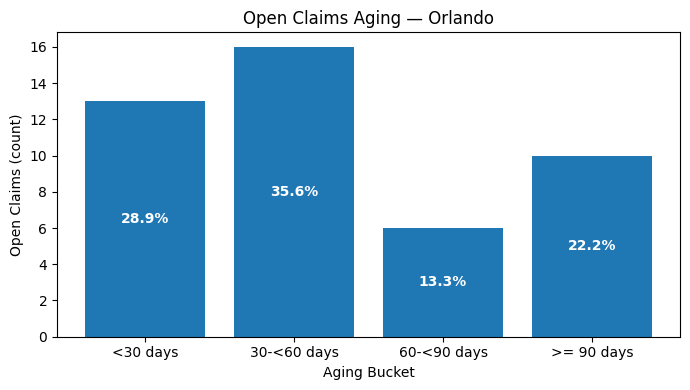

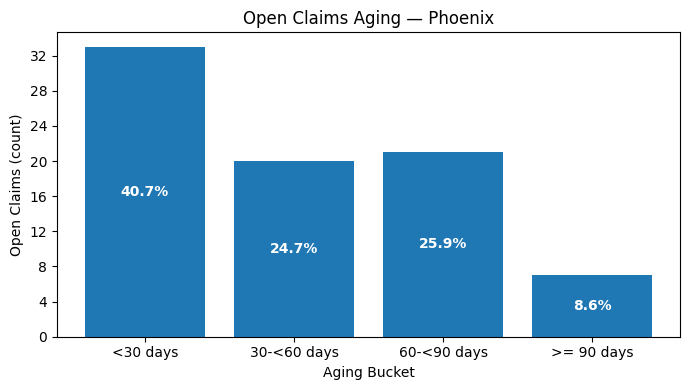

In [20]:
# --- Self-contained Aging Pareto builder (safe to run even if earlier cells weren't executed) ---

# 2) Defaults for constants only if missing
if "BUCKET_ORDER" not in globals():
    BUCKET_ORDER = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
if "bucket_regex_map" not in globals():
    bucket_regex_map = {
        r'^\s*<\s*30.*$'                 : '<30 days',
        r'^\s*30\s*-\s*<\s*60.*$'        : '30-<60 days',
        r'^\s*60\s*-\s*<\s*90.*$'        : '60-<90 days',
        r'^\s*(?:>=?\s*90|90\+|>\s*90).*': '>= 90 days',
    }
if "MAIN_WAREHOUSES" not in globals():
    # User's requested main list (no Atlanta)
    MAIN_WAREHOUSES = ["OKC", "Phoenix", "Ontario", "El Paso", "Flowood", "Orlando", "Charlotte"]

# 3) Utilities local to this cell
def _normalize_name(s: str) -> str:
    return str(s).strip().lower()

def _find_col(actual_cols, candidates):
    lookup = {_normalize_name(c): c for c in actual_cols}
    for cand in candidates:
        key = _normalize_name(cand)
        if key in lookup:
            return lookup[key]
    raise KeyError(f"None of the candidates {candidates} found in columns: {list(actual_cols)}")

def _pick_claims_df_for_aging():
    # Prefer filtered, otherwise any plausible global
    for name in ["df_filtered", "df_all", "df", "tasks", "claims"]:
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            return globals()[name], name
    raise NameError("Could not find a claims DataFrame (looked for df_filtered/df_all/df/tasks/claims). "
                    "Run the earlier cells that build df_filtered.")

def _classify_age_bucket(days: float) -> str:
    try:
        d = int(days)
    except Exception:
        return None
    if d < 30:
        return "<30 days"
    elif d < 60:
        return "30-<60 days"
    elif d < 90:
        return "60-<90 days"
    else:
        return ">= 90 days"

# 4) Build aging_long_all if neither aging_long nor aging_long_all exist
if "aging_long" not in globals() and "aging_long_all" not in globals():
    claims_df, claims_name = _pick_claims_df_for_aging()
    cols = list(claims_df.columns)

    # Detect core columns
    bucket_col = _find_col(cols, ["Bucket Name", "Bucket", "Warehouse", "Location", "Site", "Facility"])
    created_col = _find_col(cols, ["Created Date", "Date Created", "Opened Date", "Start Date"])
    completed_col = _find_col(cols, ["Completed Date", "Date Completed", "Completion Date", "Closed Date"])

    # Only OPEN claims
    open_df = claims_df[claims_df[completed_col].isna()].copy()

    # Determine as-of date for aging (use END_DATE if present, else today)
    if "END_DATE" in globals() and globals()["END_DATE"]:
        asof = pd.to_datetime(globals()["END_DATE"])
    else:
        asof = pd.Timestamp.today().normalize()

    # Compute age days
    open_df["Aging Days"] = (asof - pd.to_datetime(open_df[created_col], errors="coerce")).dt.days
    open_df["Aging Bucket"] = open_df["Aging Days"].map(_classify_age_bucket)
    open_df["Warehouse"] = open_df[bucket_col].astype(str).str.strip()

    # Ensure dataset column exists
    if any(_normalize_name(c) == "dataset" for c in open_df.columns):
        dataset_col = [c for c in open_df.columns if _normalize_name(c) == "dataset"][0]
    else:
        dataset_col = None

    grp_fields = ["Warehouse", "Aging Bucket"]
    if dataset_col:
        grp_fields.insert(0, dataset_col)

    aging_long_all = (
        open_df
        .groupby(grp_fields, dropna=False)
        .size()
        .reset_index(name="Open Count")
        .dropna(subset=["Aging Bucket"])
        .sort_values(grp_fields + ["Open Count"], ascending=[True]*len(grp_fields) + [False])
        .reset_index(drop=True)
    )

# 5) Resolve source in any case (works if user provided their own aging_long/aging_long_all)
def _resolve_aging_source():
    if 'aging_long' in globals():
        df = aging_long.copy()
    elif 'aging_long_all' in globals():
        df = aging_long_all.copy()
        # Canonicalize
        cols = {c.lower(): c for c in df.columns}
        wh_col = cols.get('warehouse', 'Warehouse') if 'warehouse' in cols else 'Warehouse'
        bucket_col = next((c for c in df.columns if 'bucket' in c.lower()), 'Aging Bucket')
        count_col = ('Open Count' if 'Open Count' in df.columns
                     else next((c for c in df.columns if c.lower() in ('open count','count','n')), None))
        if count_col is None:
            raise KeyError("Could not find an 'Open Count' (or similar) column in aging_long_all.")
        df = (df.groupby([wh_col, bucket_col], as_index=False)[count_col]
                .sum()
                .rename(columns={wh_col: 'Warehouse', bucket_col: 'Aging Bucket', count_col: 'Open Count'}))
    else:
        raise NameError("Neither 'aging_long' nor 'aging_long_all' is defined. Run the cell that builds them before this cell.")

    # Normalize names
    rename_map = {}
    for c in df.columns:
        cl = c.lower()
        if cl == 'warehouse': rename_map[c] = 'Warehouse'
        if 'bucket' in cl:     rename_map[c] = 'Aging Bucket'
        if cl in ('open count','count','n'): rename_map[c] = 'Open Count'
    df = df.rename(columns=rename_map)

    # Validate
    req = {'Warehouse', 'Aging Bucket', 'Open Count'}
    missing = req - set(df.columns)
    if missing:
        raise KeyError(f"Required columns missing: {missing}. Available: {list(df.columns)}")

    return df

# 6) Build main-warehouse aging paretos + charts
src = _resolve_aging_source()
src["Warehouse"] = src["Warehouse"].astype(str).str.strip()
src["Aging Bucket"] = (src["Aging Bucket"].astype(str).str.strip()
                       .replace(bucket_regex_map, regex=True))
src["Aging Bucket"] = pd.Categorical(src["Aging Bucket"], categories=BUCKET_ORDER, ordered=True)
src = src[src["Warehouse"].isin(MAIN_WAREHOUSES)]

pareto = (src.groupby(["Warehouse", "Aging Bucket"], as_index=False)["Open Count"]
            .sum()
            .sort_values(["Warehouse", "Aging Bucket"]))

pareto["Cum Count"] = pareto.groupby("Warehouse")["Open Count"].cumsum()
pareto["Cum %"] = (
    pareto["Cum Count"] / pareto.groupby("Warehouse")["Open Count"].transform("sum") * 100
).round(1)

pareto_tables_main = pareto.copy()

for wh, df_wh in pareto.groupby("Warehouse", sort=False):
    df_wh = (df_wh.set_index("Aging Bucket")
                  .reindex(BUCKET_ORDER)
                  .fillna({"Open Count": 0, "Cum Count": 0, "Cum %": 0})
                  .reset_index())
    x = range(len(df_wh))
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(x, df_wh["Open Count"])
    ax.set_title(f"Open Claims Aging — {wh}")
    ax.set_xlabel("Aging Bucket")
    ax.set_ylabel("Open Claims (count)")
    ax.set_xticks(list(x), df_wh["Aging Bucket"].astype(str))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # Add percentage labels inside each bar
    total = df_wh["Open Count"].sum()
    for xi, count in enumerate(df_wh["Open Count"]):
        pct = (count / total * 100) if total else 0
        ax.text(xi, count / 2, f"{pct:.1f}%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    # ax2 = ax.twinx()
    # ax2.plot(list(x), df_wh["Cum %"], marker="o")
    # ax2.set_ylabel("Cumulative %")
    # ax2.set_ylim(0, 110)
    # ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    # for xi, y in zip(x, df_wh["Cum %"]):
    #     ax2.annotate(f"{y:.0f}%", (xi, y), xytext=(0, 3), textcoords="offset points",
    #                  ha="center", fontsize=8)
    plt.tight_layout()
    plt.show()


### Cell 19: Summary
**Documentation**: ## Run Order & Configuration

## Run Order & Configuration

### Recommended Run Order
1. **Environment & Imports** – Ensure all libraries import without errors.  
2. **Data Load / Filtering** – Build the primary DataFrame(s) for analysis.  
3. **Aging Preparation** – Ensure open/closed flags and created/completed dates are present.  
4. **Aging Aggregation** – Produce `aging_long` or `aging_long_all` tables.  
5. **Pareto Tables** – Group by `Warehouse` and `Aging Bucket` and compute `Cum %`.  
6. **Charts** – Render one Pareto chart per main warehouse.

### Key Parameters (if present)
- `MAIN_WAREHOUSES`: list of warehouse codes included in charts (e.g., `['OKC','Phoenix','Ontario','El Paso','Flowood','Orlando','Charlotte']`)
- `BUCKET_ORDER`: `['<30 days','30-<60 days','60-<90 days','>= 90 days']`
- `bucket_regex_map`: mapping to coerce inconsistent labels into the standard buckets
- `END_DATE`: optional as‑of date for aging (defaults to today if not set)

> These parameters are **documented** here but remain defined in code cells to avoid breaking existing behavior. Only update them intentionally.


### Cell 20: Summary
**Documentation**: ## Troubleshooting & Maintenance

## Troubleshooting & Maintenance

### Common Issues
- **Missing aging tables**: If you see `NameError: Neither 'aging_long' nor 'aging_long_all' is defined`, run the cells that create the aging tables from your claims DataFrame(s).
- **Column not found**: The notebook attempts to locate columns like *Warehouse*, *Created Date*, and *Completed Date*. If source files change, update the column mappings in the helper code that resolves column names.
- **Chart axis/order**: Ensure `BUCKET_ORDER` matches the intended order: `<30 days`, `30-<60 days`, `60-<90 days`, `>= 90 days`.

### Support Conventions
- **Versioning**: Increment the version in the top title and update the changelog.
- **Do not silently change business logic**: If logic must change, annotate the change with a short rationale in a Markdown cell and log it in the changelog.
- **Reproducibility**: If new third‑party libraries are added, include `pip install` notes and versions in a setup cell or environment file.

## Changelog
- **v1.0** – Production freeze of working analysis. Added documentation cells (overview, function index, run order, troubleshooting) without altering code behavior.


> *This notebook was auto-annotated on 2025-09-03 21:53:43 to insert a Markdown summary before each cell. Code blocks were not modified.*